In [2]:
from one.api import ONE
from brainbox.io.one import SpikeSortingLoader
from ibllib.atlas import AllenAtlas
from brainbox.core import TimeSeries
from brainbox.processing import bin_spikes
import neo.core
from quantities import s
import quantities
import numpy as np
import pandas as pd

In [3]:
pw = 'international'
one = ONE(base_url='https://openalyx.internationalbrainlab.org', password=pw, silent=True)
Atlas = AllenAtlas()
pid = 'da8dfec1-d265-44e8-84ce-6ae9c109b8bd'

In [4]:
sl = SpikeSortingLoader(pid=pid, one=one, atlas=Atlas)
spikes, clusters, channels = sl.load_spike_sorting()
clusters = sl.merge_clusters(spikes, clusters, channels)
trials = one.load_object('SWC_043/2020-09-21/001', 'trials', collection='alf')

In [5]:
spikes['clusters']
clusters.keys()

dict_keys(['channels', 'depths', 'uuids', 'cluster_id', 'amp_max', 'amp_min', 'amp_median', 'amp_std_dB', 'contamination', 'contamination_alt', 'drift', 'missed_spikes_est', 'noise_cutoff', 'presence_ratio', 'presence_ratio_std', 'slidingRP_viol', 'spike_count', 'firing_rate', 'label', 'x', 'y', 'z', 'acronym', 'atlas_id', 'axial_um', 'lateral_um'])

(<Figure size 1152x648 with 4 Axes>,
 array([[<AxesSubplot: title={'center': '2020-09-21_1_SWC_043_probe00, da8dfec1-d265-44e8-84ce-6ae9c109b8bd \n17_575_242 spikes, 914 clusters'}>,
         <AxesSubplot: >],
        [<AxesSubplot: xlabel='time (secs)', ylabel='depth (um)'>,
         <AxesSubplot: title={'center': 'alf'}>]], dtype=object))

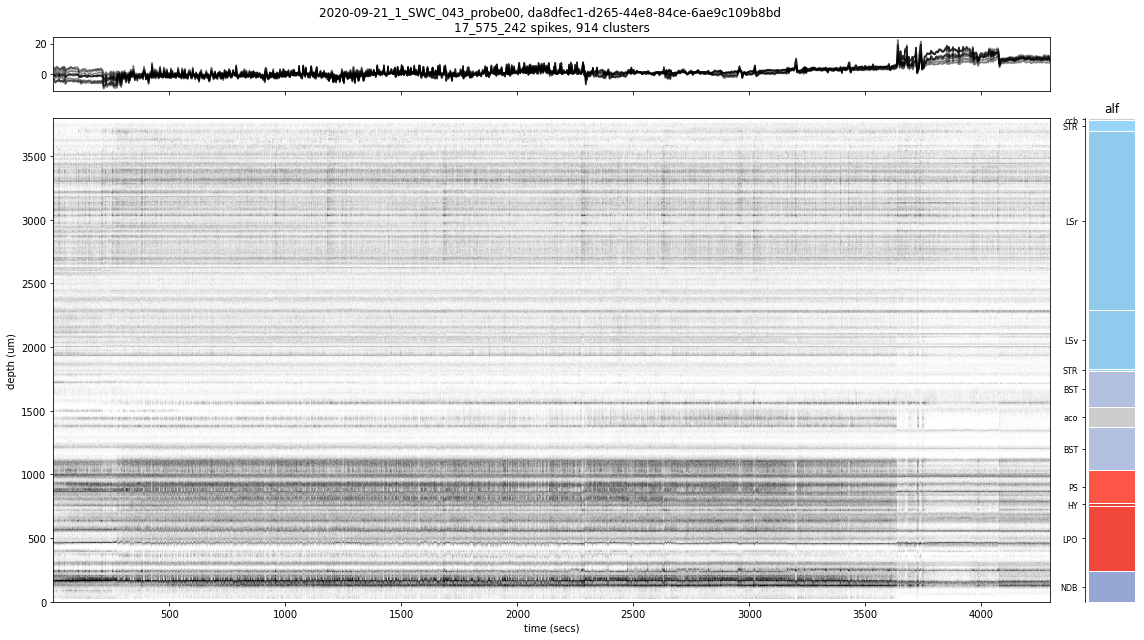

In [6]:
sl.raster(spikes, channels)

In [7]:
good_clusterIDs = clusters['cluster_id'][clusters['label'] == 1] # Find good clusters
good_cluster_loc = np.isin(spikes['clusters'], good_clusterIDs)

In [8]:
good_spikes = {}
for i in spikes:
    good_spikes[i] = spikes[i][good_cluster_loc]

In [ ]:
# trials_spikes = [] # The Spike times and results of each trial

# for i, interval in enumerate(trials['intervals']):
#     time_range = ((good_spikes['times']>interval[0]) & (good_spikes['times']<interval[1])) #Find the spikes corresponding to the current interval
#     spike_range = {}
    
#     for key in good_spikes:
#         spike_range[key] = good_spikes[key][time_range]
        
#     spike_range['goCue_times'] = trials['goCue_times'][i]
#     spike_range['firstMovement_times'] = trials['firstMovement_times'][i]
#     spike_range['choice'] = trials['choice'][i]
#     spike_range['feedbackType'] = trials['feedbackType'][i]
    
#     # Bin Spikes based on time= 0.1 seconds, per cluster
#     df = pd.DataFrame(data={'clusters':spike_range['clusters'], 'times':spike_range['times']})
#     hist_bins = np.arange(interval[0], interval[1], 0.1)
#     df = df.groupby('clusters')['times'].apply(list)
    
#     hist_rows = []
#     for i in df.iloc:
#         hist_rows.append(np.histogram(i, hist_bins)[0])
#     spikes_df = pd.DataFrame(hist_rows, columns=hist_bins[:-1], index=df.index) # Clusters are assumed to be good neurons
#     spike_range['spikes_df'] = spikes_df
    
#     trials_spikes.append(spike_range)

In [9]:
# good_spikes
df = pd.DataFrame(data = {'clusters':good_spikes['clusters'], 'times':good_spikes['times']})
df = df.groupby('clusters')['times'].apply(np.array)
df

clusters
0      [209.12262990663282, 209.51279330259365, 212.4...
1      [0.1517878943612596, 0.17438770331575443, 0.17...
6      [8.37271839944542, 19.70735591641346, 20.54201...
35     [0.014489055004970183, 0.0210223331098094, 0.0...
37     [0.14105465176045232, 0.2822867912002674, 0.43...
                             ...                        
830    [1.7863407434786094, 4.500484466369084, 4.5077...
856    [4.758082288788458, 15.148494454349457, 18.347...
861    [110.12356076326957, 116.75200504126173, 120.8...
869    [2.1751707898712085, 6.305402541985583, 10.157...
913    [0.9213480556185195, 2.611633766936334, 5.3863...
Name: times, Length: 165, dtype: object

In [35]:
trials.keys()

dict_keys(['goCueTrigger_times', 'stimOff_times', 'probabilityLeft', 'feedbackType', 'response_times', 'choice', 'firstMovement_times', 'contrastLeft', 'contrastRight', 'stimOn_times', 'rewardVolume', 'feedback_times', 'goCue_times', 'intervals'])

In [61]:
### Important cell
spiketrains = []

for i in range(len(trials['goCueTrigger_times'])): # trial #
    x = []
    for j in df: # all spike times, per neuron
        inds = ((j>trials['goCueTrigger_times'][i]) & (j<trials['firstMovement_times'][i])) # From go queue to first movement
        sp = neo.core.SpikeTrain(j[inds] * s, trials['firstMovement_times'][i])
        x.append(sp)
    
    spiketrains.append(x)

In [69]:
len(spiketrains)

529

In [ ]:
# spiketrains = []
# for i in trials_spikes:
#     df = i['spikes_df']
#     cols = list(i['spikes_df'].columns)
#     rows = []
#     for row in df.iterrows():
#         rows.append(row)
#     trials = []
#     for row in rows:
#         out = []
#         rn = list(row[1].to_dict().keys())
#         for i, val in enumerate(row[1]):
#             if val != 0:
#                 out.append(rn[i])
#         sp = neo.core.SpikeTrain(out * s, rn[-1])
#         trials.append(sp)
#     spiketrains.append(trials)


In [74]:
from elephant.gpfa import GPFA



# specify fitting parameters
bin_size = 13 * quantities.ms
latent_dimensionality = 2

gpfa_2dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality, em_max_iters=10)

In [75]:
gpfa_2dim.fit(spiketrains[0:5])

c:\Users\asing\AppData\Local\Programs\Python\Python39\lib\site-packages\elephant\conversion.py:1170: UserWarning: Binning discarded 15 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


Initializing parameters using factor analysis...
Hello
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Fitting GPFA model...


GPFA(bin_size=array(13.) * ms, em_max_iters=10, x_dim=2)

In [32]:
len(spiketrains[4])

165

In [49]:
spiketrains[0]

[SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,
 SpikeTrain,

In [76]:
trajectories = gpfa_2dim.transform(spiketrains[0:1])

c:\Users\asing\AppData\Local\Programs\Python\Python39\lib\site-packages\elephant\conversion.py:1170: UserWarning: Binning discarded 10 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


MemoryError: Unable to allocate 3.22 GiB for an array with shape (20804, 20804) and data type float64

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

linewidth_single_trial = 0.5
color_single_trial = 'C0'
alpha_single_trial = 0.5

linewidth_trial_average = 2
color_trial_average = 'C1'

ax1.set_title('Original latent dynamics')
ax1.set_xlabel('Dim 1')
ax1.set_ylabel('Dim 2')
ax1.set_aspect(1)
ax1.plot(oscillator_trajectory_2dim[0], oscillator_trajectory_2dim[1])

ax2.set_title('Latent dynamics extracted by GPFA')
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_aspect(1)
# single trial trajectories
for single_trial_trajectory in trajectories:
    ax2.plot(single_trial_trajectory[0], single_trial_trajectory[1], '-', lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
# trial averaged trajectory
average_trajectory = np.mean(trajectories, axis=0)
ax2.plot(average_trajectory[0], average_trajectory[1], '-', lw=linewidth_trial_average, c=color_trial_average, label='Trial averaged trajectory')
ax2.legend()

plt.tight_layout()
plt.show()